# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

## Task 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [1]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 47.08 KiB | 2.24 MiB/s, done.


In [13]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()


data[:100] #print 100 names

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [14]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [15]:
#covert character to number
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [16]:
tokenizer.fit_on_texts(data)

In [17]:
char_to_index = tokenizer.word_index
index_to_char = dict((v,k) for k, v in char_to_index.items())

print(index_to_char) #vocabulary convert to numbers

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


## Task 3

1. Converting between names and sequences

In [18]:
names = data.splitlines()
names[:10] #print first 10 names

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [19]:
tokenizer.texts_to_sequences(names[0])  #numeric representation for 'jumpa\t'

[[25], [16], [12], [20], [2], [1]]

In [20]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name] #

In [21]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [22]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i!=0]) # because 0 is not defined

In [23]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [24]:
sequences = []

for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2: # atleast have 2 characters
    sequences += [seq[:i] for i in range(2, len(seq) + 1)]

In [25]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [26]:
max_len = max([len(x) for x in sequences])

print(max_len)

33


In [28]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre', # means before(pre) padded added then value added to make max_len
    maxlen=max_len
)

print(padded_sequences[0])  # last value is going to be label

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [29]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [31]:
x, y = padded_sequences[:,:-1], padded_sequences[:,-1] # last value is going to be label

print(x.shape)
print(y.shape) #label

(88279, 32)
(88279,)


In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y) # default split is 30% for test

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(66209, 32) (22070, 32)
(66209,) (22070,)


In [36]:
num_chars = len(char_to_index.keys())+1  # +1 for 0
print(num_chars) # 26 characters 0, ' ', \t

29


## Task 6: Creating the Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM, Bidirectional, Dense

model = Sequential([
    Embedding(num_chars, 8, input_length = max_len-1), # -1 for split label
    Conv1D(64,5,strides=1, activation='tanh', padding='causal'), # causal is for time independent
    MaxPool1D(2),
    LSTM(32),
    Dense(num_chars, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer ='adam',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16229 (63.39 KB)
Trainable params: 16229 (63.39 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

## Task 7: Training the Model

In [38]:
h = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 50,
    verbose = 2,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]

)

Epoch 1/50
2070/2070 - 32s - loss: 2.7785 - accuracy: 0.1789 - val_loss: 2.6055 - val_accuracy: 0.2189 - 32s/epoch - 15ms/step
Epoch 2/50
2070/2070 - 39s - loss: 2.5443 - accuracy: 0.2353 - val_loss: 2.5204 - val_accuracy: 0.2449 - 39s/epoch - 19ms/step
Epoch 3/50
2070/2070 - 37s - loss: 2.4731 - accuracy: 0.2570 - val_loss: 2.4716 - val_accuracy: 0.2589 - 37s/epoch - 18ms/step
Epoch 4/50
2070/2070 - 51s - loss: 2.4266 - accuracy: 0.2649 - val_loss: 2.4340 - val_accuracy: 0.2614 - 51s/epoch - 25ms/step
Epoch 5/50
2070/2070 - 49s - loss: 2.3883 - accuracy: 0.2751 - val_loss: 2.4012 - val_accuracy: 0.2736 - 49s/epoch - 24ms/step
Epoch 6/50
2070/2070 - 40s - loss: 2.3564 - accuracy: 0.2855 - val_loss: 2.3844 - val_accuracy: 0.2782 - 40s/epoch - 19ms/step
Epoch 7/50
2070/2070 - 32s - loss: 2.3292 - accuracy: 0.2968 - val_loss: 2.3584 - val_accuracy: 0.2899 - 32s/epoch - 15ms/step
Epoch 8/50
2070/2070 - 38s - loss: 2.3044 - accuracy: 0.3019 - val_loss: 2.3446 - val_accuracy: 0.2909 - 38s/ep

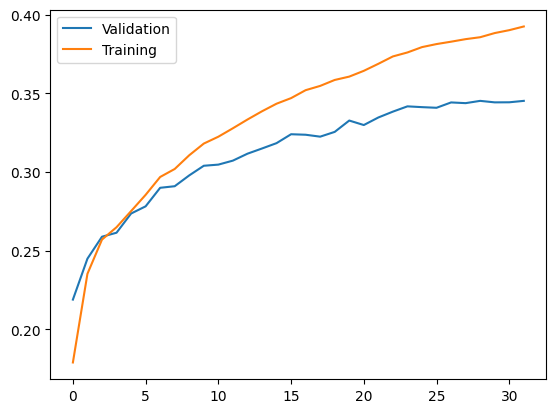

In [39]:
from matplotlib import pyplot as plt

epochs_ran = len(h.history['loss'])

plt.plot(range(0, epochs_ran), h.history['val_accuracy'], label='Validation')
plt.plot(range(0, epochs_ran), h.history['accuracy'], label='Training')

plt.legend()

plt.show()


## Task 8: Generate Names!

In [40]:
def generate_names(seed):
  for i in range(0,40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre', maxlen=max_len-1, truncating='pre')

    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break

  print(seed)

In [41]:
generate_names('a')

1/1 [==============================] - 0s 24ms/step
artenica gallia	


In [43]:
generate_names('pr')

1/1 [==============================] - 0s 29ms/step
prock start	
